# Tutorial: Quick start
Author info: Jiaqi Cai@Department of Physics, University of Washington, Seattle, WA 98195, email address caidish[at]uw.edu.

This tutorial shows how to use this package to do all the data acqusition from:
- Sweep0D: monitor all the *follow_params* followed parameters as a function of system time. 
- Sweep1D: monitor all the followed parameters when sweeping one paramter. This sweep1D can do sweep one-way or back-and-forth, or continously. 
- Sweep2D: monitor all the followed parameters when sweeping two paramters in a back-and-forth scan. The inner parameter will be swept back and forth and outer parameter will step when one loop finished. 
- SimuSweep: same as sweep1D, but two parameters could be scanned simutaneously. 
- SweepQueue: consist of the queue of sweep0D, sweep1D, sweep2D and SimuSweep and any user defined function. The sweeps will be run one by one.

I will use the MockParabola function from qcodes' test instrument. The simulated device Mockparabola has main parameters *parabola*, *x*,*y*,*z* and *noise*. The output parabola is a quadric function of x,y,z in the presence of noise. 

## Import essential modules

In [1]:
import qcodes as qc
from qcodes.instrument_drivers.mock_instruments import MockParabola

from measureit import (
    GateLeakage,
    SimulSweep,
    Sweep0D,
    Sweep1D,
    Sweep2D,
    get_data_dir,
    get_path,
)
from measureit.tools import ensure_qt, init_database

ensure_qt()
# Set MEASUREIT_FORCE_QT=1 to bypass the probe once Qt is configured.
from measureit.tools.sweep_queue import DatabaseEntry, SweepQueue


MeasureIt data directory: /home/wangs/instrmcptest
To change: measureit.set_data_dir('/path')



In [2]:
# where the data will be saved
print(f"Data directory: {get_data_dir()}")
print(f"Database directory: {get_path('databases')}")

Data directory: /home/wangs/instrmcptest
Database directory: /home/wangs/instrmcptest/Databases


## Define the instrument(s)

We imported a test instrument 'MockParabola' from qcodes' tests. Other supported drivers could be found in [qcodes driver list](https://github.com/QCoDeS/Qcodes/tree/master/qcodes/instrument_drivers) and [contributed driver list](https://github.com/QCoDeS/Qcodes_contrib_drivers/tree/master/qcodes_contrib_drivers/drivers). We also have some user contributed driver (e.g. old lakeshore)

In [3]:
instr0 = MockParabola(name="test_instrument0")
instr0.noise.set(3)
instr0.parabola.label = "Value of instr0"
instr1 = MockParabola(name="test_instrument1")
instr1.noise.set(10)
instr1.parabola.label = "Value of instr1"

What we do is to create two instances of MockParabola. In other cases when people need to deal with multiple instruments, they can be imported and defined one by one. For parameters, the 'label' property will appear as the y-axis name when we dynamically display the measurement result. 

## Sweep 0d to monitor the noise

In [4]:
s = Sweep0D(
    inter_delay=0.1, save_data=True, plot_bin=4, max_time=20
)  # inter_delay is the delay after qcodes collecting all data. inter_delay = 0.05 corresponds to a maximum sampling rate @200S/s.
follow_params = {  # Define which parameters you want to follow (plot and/or save)
    instr0.parabola,
    instr1.parabola,
}
s.follow_param(*follow_params)

The 0d sweep which monitors the output will last for max_time (in unit of seconds), which now is set as 100s. 

In [5]:
try:
    # Make sure database_name and the path are set to the correct values!
    database_name = "Test_database.db"
    exp_name = "testsweep"
    sample_name = "test0d"
    init_database(database_name, exp_name, sample_name, s)
except:
    print("Error opening database")

In [6]:
print(s)

0D Sweep for 20 seconds.


In [7]:
s.start()

In [8]:
ds = qc.dataset.load_by_id(1)

In [9]:
ds.metadata

{'measureit': '{"class": "Sweep0D", "module": "measureit.sweep.sweep0d", "attributes": {"inter_delay": 0.1, "save_data": true, "plot_data": true, "plot_bin": 4, "max_time": 20}, "set_param": null, "follow_params": {"test_instrument1.parabola": ["test_instrument1", "qcodes.instrument_drivers.mock_instruments", "MockParabola"], "test_instrument0.parabola": ["test_instrument0", "qcodes.instrument_drivers.mock_instruments", "MockParabola"]}}'}

Before the max_time reaches, one way to pause is to use ESC on your keyboard. Another way to stop it is run the code below. **Note that closing the plotter's window doesn't neccessarity stops the data acquisition.**

In [10]:
s.progress_state.state

<SweepState.DONE: 'done'>

In [11]:
s.kill()

When the sweep is running on the background, however, although the data is acquired in another process, the plotting is still requiring CPU time from this notebook's thread. time.sleep() will pause the plotting but preassumely not the data acquisition. 

## Sweep 1d
The sweep 1d function takes one parameter import, which is instr0's x parameter.
It also requires a start point, end point, rate. **If the parameter is not at 'start', it will safely sweep to 'start' with the rate, making sure there is no jump in any physical instrument.**

In [12]:
start = 0
end = 10
rate = 0.02
s = Sweep1D(
    instr0.x,
    start,
    end,
    rate,
    inter_delay=0.05,
    save_data=True,
    bidirectional=True,
    plot_bin=4,
    continual=False,
)
follow_params = {  # Define which parameters you want to follow (plot and/or save)
    instr0.parabola,
    instr1.parabola,
}
s.follow_param(*follow_params)

In [13]:
s._params[1]

<qcodes.parameters.parameter.Parameter: parabola at 135770530652944>

In [14]:
try:
    # Make sure database_name and the path are set to the correct values!
    database_name = "Test_database.db"
    exp_name = "testsweep"
    sample_name = "test1d"
    init_database(database_name, exp_name, sample_name, s)
except:
    print("Error opening database")

In [15]:
print(s)

1D Sweep of x from 0 to 10, with step size 0.02.


In [16]:
ensure_qt()
s.start()

2025-11-14 15:52:11,272 | measureit.sweeps.Sweep1D | INFO | Ramping to our starting setpoint value of 0 (a.u.)
2025-11-14 15:52:11,275 | measureit.sweeps.Sweep1D | INFO | Done ramping x to 0 (a.u.)
2025-11-14 15:52:11,276 | measureit.sweeps.Sweep1D | INFO | Sweeping x to 10 (a.u.)


In [17]:
s.progress_state.state

<SweepState.DONE: 'done'>

During the scan, like sweep0d, there are multiple ways to stop it. Besides, the 'spacebar' could revert the scanning axis. 

In [18]:
s.kill()

## Limit test
This limit test will sweep back automatically once a limit is triggered, which can be used for gate limit test. 

In [19]:
gl = GateLeakage(
    instr0.x,
    instr0.parabola,
    max_I=10,
    limit=20,
    step=0.1,
    inter_delay=0.2,
    save_data=False,
)

In [ ]:
ensure_qt()
gl.start()

In [ ]:
gl.kill()

## Simulsweep
The simulsweep function mimics sweep 1D but take two different parameter. The step must be set correctly that the total steps for each parameters are equal. 

In [20]:
parameter_dict_forward = {
    instr0.x: {"start": 0, "stop": 5, "step": 0.04},
    instr1.x: {"start": 0, "stop": 10, "step": 0.08},
}
sweep_args = {
    "bidirectional": True,
    "plot_bin": 4,
    "continual": False,
    "save_data": True,
    "inter_delay": 0.05,
}
s = SimulSweep(parameter_dict_forward, **sweep_args)  # Likely want to save this sweep
follow_params = {  # Define which parameters you want to follow (plot and/or save)
    instr0.parabola,
    instr1.parabola,
}
s.follow_param(*follow_params)

In [21]:
try:
    # Make sure database_name and the path are set to the correct values!
    database_name = "Test_database.db"
    exp_name = "testsweep"
    sample_name = "testSimu"
    init_database(database_name, exp_name, sample_name, s)
except:
    print("Error opening database")

In [22]:
ensure_qt()
s.start()

2025-11-14 15:53:18,336 | measureit.sweeps.SimulSweep | INFO | Ramping to our starting setpoints.
2025-11-14 15:53:18,338 | measureit.sweeps.SimulSweep | INFO | Already at the values, no ramp needed.
2025-11-14 15:53:18,340 | measureit.sweeps.SimulSweep | INFO | Done ramping!
2025-11-14 15:53:18,341 | measureit.sweeps.SimulSweep | INFO | Starting our sweep.


In [33]:
s.progress_state.state

<SweepState.DONE: 'done'>

In [23]:
s.kill()

## Sweep Queue
The most important application of this code is that you can freely stack all sweep types and user defined function together. Here I will show a sweepqueue that:
- sweep instr0's x from 0 to 5
- print a dummy string 1
- sweep instr1's x and y from 0 to 5
- print a dummy string 2

In [24]:
run = 20


def dummystring(index):
    if index == 1:
        print("Lorem ipsum dolor sit amet, consectetur adipiscing elit.")
    elif index == 2:
        print(
            "Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat."
        )

In [25]:
sq = SweepQueue()
follow_params = {  # Define which parameters you want to follow (plot and/or save)
    instr0.parabola,
    instr1.parabola,
}

SweepQueue accept sweep object and associated database if save_data is set to be True. 

The += operator is overload for SweepQueue, so that the sweep,databaseentry tuple pair can be directly added into it. Same thing as the append function

In [26]:
# set up the sweep
start = 0
end = 5
rate = 0.2
s1 = Sweep1D(
    instr0.x,
    start,
    end,
    rate,
    inter_delay=0.2,
    save_data=True,
    bidirectional=True,
    plot_bin=4,
    continual=False,
)
s1.follow_param(*follow_params)

db_name = "Test_database.db"
db_path = str(get_path("databases") / db_name)
exp_name = "testsweepqueue"
sample_name = "test1d"

# set up the database
db_entry = DatabaseEntry(db_path, exp_name, sample_name)
sq += (db_entry, s1)

In [27]:
# add dummy string print
# sq += (dummystring, 1)

In [28]:
# set up the sweep
parameter_dict_forward = {
    instr0.x: {"start": 0, "stop": 5, "step": 0.02},
    instr0.y: {"start": 0, "stop": 5, "step": 0.02},
}
sweep_args = {
    "bidirectional": True,
    "plot_bin": 4,
    "continual": False,
    "save_data": True,
    "inter_delay": 0.1,
}
s2 = SimulSweep(parameter_dict_forward, **sweep_args)  # Likely want to save this sweep
s2.follow_param(*follow_params)
db_name = "Test_database.db"
db_path = str(get_path("databases") / db_name)
exp_name = "testsweepqueue"
sample_name = "testsimulsweep"

# set up the database
db_entry = DatabaseEntry(db_path, exp_name, sample_name)
sq += (db_entry, s2)

In [29]:
# add dummy string print
# sq += (dummystring, 2)

The SweepQueue is iterable, so you can iterate it and print every one's name

In [30]:
for n, s in enumerate(sq):
    print(str(n) + ". " + str(s))

0. Database entry: /home/wangs/instrmcptest/Databases/Test_database.db | Experiment: testsweepqueue | Sample: test1d
1. 1D Sweep of x from 0 to 5, with step size 0.2.
2. Database entry: /home/wangs/instrmcptest/Databases/Test_database.db | Experiment: testsweepqueue | Sample: testsimulsweep
3. SimulSweep of x from 0 to 5, with step 0.02, and y from 0 to 5, with step 0.02.


In [31]:
ensure_qt()
sq.start()

2025-11-14 15:53:41,114 | measureit.sweeps.queue | INFO | Starting sweeps
2025-11-14 15:53:41,124 | measureit.sweeps.queue | INFO | Database entry: /home/wangs/instrmcptest/Databases/Test_database.db | Experiment: testsweepqueue | Sample: test1d
2025-11-14 15:53:41,632 | measureit.sweeps.queue | INFO | Waiting 1.0 s for database initialization...
2025-11-14 15:53:45,484 | measureit.sweeps.queue | INFO | Starting sweep of x from 0 (a.u.) to 5 (a.u.)
2025-11-14 15:53:45,485 | measureit.sweeps.Sweep1D | INFO | Ramping to our starting setpoint value of 0 (a.u.)
2025-11-14 15:53:45,487 | measureit.sweeps.Sweep1D | INFO | Done ramping x to 0 (a.u.)
2025-11-14 15:53:45,488 | measureit.sweeps.Sweep1D | INFO | Sweeping x to 5 (a.u.)


In [32]:
sq.progress_state.state

<SweepState.DONE: 'done'>

In [33]:
sq.kill()

2025-11-14 15:54:59,969 | measureit.sweeps.queue | INFO | No current action to kill.


## Sweep 2D
The 2D sweep, which is sweeping one parameter back and forth and then step one of the parameter, could be easily achieved by using sweep queue. 
Sweep2d is a good substitute of sweepqueue (though many users still use sweepqueue for 2D sweep) if you only want to take a 2d map in a single file. Here we will sweep Mockparabola's x and y to generate a 2d map. 

In [34]:
# define 2d map
outer_para = instr0.y
outer_dv = 0.5
outer_start = -2.5
outer_end = 2.5

inner_para = instr0.x
inner_dv = 0.1
inner_start = -2.5
inner_end = 2.5

multiplier = 4
inter_delay = 0.1
outer_delay = 0.5
s = Sweep2D(
    [inner_para, inner_start, inner_end, inner_dv],
    [outer_para, outer_start, outer_end, outer_dv],
    inter_delay=inter_delay,
    outer_delay=outer_delay,
    save_data=True,
    plot_data=True,
    complete_func=None,
    update_func=None,
    plot_bin=5,
    back_multiplier=multiplier,
    out_ministeps=1,
)
follow_params = {  # Define which parameters you want to follow (plot and/or save)
    instr0.parabola,
    instr1.parabola,
}
s.follow_param(*follow_params)
print(s)

2025-11-14 15:55:01,158 | measureit.sweeps.Sweep2D | INFO | Heatmap will follow a random parameter by default


2D Sweep of y from -2.5 to 2.5 with step 0.5, while sweeping x from -2.5 to 2.5 with step 0.1. Heatmap follows Value of instr1. 


In [35]:
# define the parameter to follow by the heatmap
s.follow_heatmap_param([instr0.parabola, instr1.parabola])

In [36]:
print(s)

2D Sweep of y from -2.5 to 2.5 with step 0.5, while sweeping x from -2.5 to 2.5 with step 0.1. Heatmap follows Value of instr0. 


In [37]:
try:
    # Make sure database_name and the path are set to the correct values!
    database_name = "Test_database.db"
    exp_name = "testsweep"
    sample_name = "test2d"
    init_database(database_name, exp_name, sample_name, s)
except:
    print("Error opening database")

In [38]:
ensure_qt()
s.start()

2025-11-14 15:55:03,018 | measureit.sweeps.Sweep1D | INFO | Sweeping y to -2.5 (a.u.)
2025-11-14 15:55:03,079 | measureit.sweeps.Sweep2D | INFO | Ramping y to -2.5 . . . 


In [ ]:
print(s.progress_state.state)
print(s.in_sweep.progress_state.state)

In [17]:
s.kill()

In [18]:
# Comprehensive test script

In [19]:
"""
Comprehensive test script for SweepQueue with mixed sweep types.
Tests all the bug fixes implemented for sweep_queue.
"""

import time

from measureit import DatabaseEntry, SimulSweep, Sweep1D, Sweep2D, SweepQueue
from measureit.config import get_path

# Assuming instr0 and instr1 are already set up in your environment
# If not, you'll need to initialize them first

database_name = "Test_database.db"
exp_name = "testsweep"
sample_name = "test1d"
init_database(database_name, exp_name, sample_name)

# Create the SweepQueue
sq = SweepQueue(inter_delay=0.5)  # Small delay between sweeps

# Define follow parameters for all sweeps
follow_params = {
    instr0.parabola,
    instr1.parabola,
}

print("=" * 60)
print("COMPREHENSIVE SWEEP QUEUE TEST")
print("=" * 60)

# ============================================================
# SWEEP 1: Simple 1D sweep (baseline test)
# ============================================================
print("\n1. Creating simple 1D sweep...")
s1 = Sweep1D(
    instr0.x,
    start=0,
    stop=2,
    step=0.5,
    inter_delay=0.1,
    save_data=True,  # Save data to see it in database
    bidirectional=False,
    plot_bin=4,
)
s1.follow_param(*follow_params)
sq.append(s1)

# ============================================================
# SWEEP 2: SimulSweep (tests SimulSweep compatibility)
# ============================================================
print("2. Creating SimulSweep...")
parameter_dict = {
    instr0.x: {"start": 0, "stop": 3, "step": 0.5},
    instr0.y: {"start": 0, "stop": 3, "step": 0.5},
}
sweep_args = {
    "bidirectional": True,
    "plot_bin": 4,
    "continual": False,
    "save_data": True,
    "inter_delay": 0.1,
}
s2 = SimulSweep(parameter_dict, **sweep_args)
s2.follow_param(*follow_params)
sq.append(s2)

# ============================================================
# DATABASE ENTRY 1: Switch to new database/experiment
# ============================================================
print("3. Adding DatabaseEntry to switch database...")
db_name1 = "Test_SweepQueue_DB1.db"
db_path1 = str(get_path("databases") / db_name1)
exp_name1 = f"experiment_2D_{int(time.time())}"
sample_name1 = "sample_2D"
db_entry1 = DatabaseEntry(db_path1, exp_name1, sample_name1)
sq.append(db_entry1)

# ============================================================
# SWEEP 3: Your 2D sweep (tests 2D sweep after database switch)
# ============================================================
print("4. Creating 2D sweep...")
outer_para = instr0.y
outer_dv = 0.5
outer_start = -2.5
outer_end = 2.5

inner_para = instr0.x
inner_dv = 0.1
inner_start = -2.5
inner_end = 2.5

multiplier = 4
inter_delay = 0.1
outer_delay = 1

s3_2d = Sweep2D(
    [inner_para, inner_start, inner_end, inner_dv],
    [outer_para, outer_start, outer_end, outer_dv],
    inter_delay=inter_delay,
    outer_delay=outer_delay,
    save_data=True,
    plot_data=True,
    complete_func=None,
    update_func=None,
    plot_bin=5,
    back_multiplier=multiplier,
    out_ministeps=1,
)
s3_2d.follow_param(*follow_params)
sq.append(s3_2d)
print(f"2D Sweep: {s3_2d}")

# ============================================================
# SWEEP 4: Another 1D sweep (tests continuation after 2D)
# ============================================================
print("5. Creating another 1D sweep...")
s4 = Sweep1D(
    instr1.x,
    start=-1,
    stop=1,
    step=0.2,
    inter_delay=0.1,
    save_data=True,
    bidirectional=True,
    plot_bin=4,
)
s4.follow_param(*follow_params)
sq.append(s4)

# ============================================================
# DATABASE ENTRY 2: Switch to another database
# ============================================================
print("6. Adding second DatabaseEntry...")
db_name2 = "Test_SweepQueue_DB2.db"
db_path2 = str(get_path("databases") / db_name2)
exp_name2 = f"experiment_final_{int(time.time())}"
sample_name2 = "sample_final"
db_entry2 = DatabaseEntry(db_path2, exp_name2, sample_name2)
sq.append(db_entry2)

# ============================================================
# SWEEP 5: SimulSweep with ramp_to_start test
# ============================================================
print("7. Creating final SimulSweep with different starting positions...")
# This tests the ramp_to_start edge case fix
parameter_dict2 = {
    instr0.x: {"start": 0, "stop": 5, "step": 0.02},
    instr1.x: {"start": 0, "stop": 10, "step": 0.04},
}
sweep_args2 = {
    "bidirectional": True,
    "plot_bin": 4,
    "continual": False,
    "save_data": True,
    "inter_delay": 0.05,
}
s5 = SimulSweep(parameter_dict2, **sweep_args2)
s5.follow_param(*follow_params)
sq.append(s5)

# ============================================================
# SWEEP 6: Quick 1D sweep to verify queue completion
# ============================================================
print("8. Creating final quick 1D sweep...")
s6 = Sweep1D(
    instr0.x,
    start=0,
    stop=1,
    step=0.2,
    inter_delay=0.1,
    save_data=True,
    bidirectional=False,
    plot_bin=2,
)
s6.follow_param(*follow_params)
sq.append(s6)

# ============================================================
# SUMMARY AND EXECUTION
# ============================================================
print("\n" + "=" * 60)
print("SWEEP QUEUE SUMMARY")
print("=" * 60)
print(f"Total items in queue: {len(sq.future_actions)}")
print("\nQueue contents:")
for i, item in enumerate(sq.future_actions, 1):
    if isinstance(item, DatabaseEntry):
        print(f"  {i}. DatabaseEntry -> {item}")
    else:
        print(f"  {i}. {item}")

print("\n" + "=" * 60)
print("ESTIMATED TIME")
print("=" * 60)
total_time = sq.estimate_time(verbose=True)

print("\n" + "=" * 60)
print("STARTING SWEEP QUEUE")
print("=" * 60)
print("\nPress Ctrl+C to stop the queue at any time")
print("Starting in 3 seconds...\n")
time.sleep(3)

# Start the sweep queue
# Use rts=True to test ramp_to_start functionality
sq.start(rts=True)

print("\n" + "=" * 60)
print("SWEEP QUEUE TEST COMPLETE")
print("=" * 60)
print("\nCheck the following to verify all fixes:")
print("1. No 'begin_next' called multiple times messages")
print("2. Sweeps continue after DatabaseEntry without stopping")
print("3. Data saved to correct databases/experiments")
print("4. 2D sweep completes successfully")
print("5. SimulSweep with different starting positions works")
print("6. All sweeps complete in order")
print("\nDatabases created:")
print(f"  - {db_name1} (contains 2D sweep and 1D sweep)")
print(f"  - {db_name2} (contains SimulSweep and final 1D sweep)")

There is (are) already experiment(s) with the name of testsweep and sample name of test1d in the database.
2025-11-14 13:53:16,820 | measureit.sweeps.Sweep2D | INFO | Heatmap will follow a random parameter by default
2025-11-14 13:53:16,828 | measureit.sweeps.queue | INFO | Estimated time for the SweepQueue to run: 0h: 1m:56s


COMPREHENSIVE SWEEP QUEUE TEST

1. Creating simple 1D sweep...
2. Creating SimulSweep...
3. Adding DatabaseEntry to switch database...
4. Creating 2D sweep...
2D Sweep: 2D Sweep of y from -2.5 to 2.5 with step 0.5, while sweeping x from -2.5 to 2.5 with step 0.1. Heatmap follows Value of instr0. 
5. Creating another 1D sweep...
6. Adding second DatabaseEntry...
7. Creating final SimulSweep with different starting positions...
8. Creating final quick 1D sweep...

SWEEP QUEUE SUMMARY
Total items in queue: 8

Queue contents:
  1. 1D Sweep of x from 0 to 2, with step size 0.5.
  2. SimulSweep of x from 0 to 3, with step 0.5, and y from 0 to 3, with step 0.5.
  3. DatabaseEntry -> Database entry: /home/wangs/instrmcptest/Databases/Test_SweepQueue_DB1.db | Experiment: experiment_2D_1763146396 | Sample: sample_2D
  4. 2D Sweep of y from -2.5 to 2.5 with step 0.5, while sweeping x from -2.5 to 2.5 with step 0.1. Heatmap follows Value of instr0. 
  5. 1D Sweep of x from -1 to 1, with step size 

2025-11-14 13:53:19,831 | measureit.sweeps.queue | INFO | Starting sweeps
2025-11-14 13:53:19,844 | measureit.sweeps.queue | INFO | Starting sweep of x from 0 (a.u.) to 2 (a.u.)
2025-11-14 13:53:19,846 | measureit.sweeps.Sweep1D | INFO | Ramping to our starting setpoint value of 0 (a.u.)
2025-11-14 13:53:19,850 | measureit.sweeps.Sweep1D | INFO | Sweeping x to 0 (a.u.)
2025-11-14 13:53:19,964 | measureit.sweeps.Sweep1D | INFO | Ramping x to 0 (a.u.) . . . 



SWEEP QUEUE TEST COMPLETE

Check the following to verify all fixes:
1. No 'begin_next' called multiple times messages
2. Sweeps continue after DatabaseEntry without stopping
3. Data saved to correct databases/experiments
4. 2D sweep completes successfully
5. SimulSweep with different starting positions works
6. All sweeps complete in order

Databases created:
  - Test_SweepQueue_DB1.db (contains 2D sweep and 1D sweep)
  - Test_SweepQueue_DB2.db (contains SimulSweep and final 1D sweep)


In [20]:
sq.progress_state.state

<SweepState.DONE: 'done'>

In [21]:
sq.kill()

2025-11-14 13:56:12,569 | measureit.sweeps.queue | INFO | No current action to kill.


SWEEP QUEUE DATA VERIFICATION

CHECKING DEFAULT DATABASE

Analyzing: Default Database (experiments.db)
Path: /home/wangs/instrmcptest/Databases/Test_.db
⚠️  Database Default Database (experiments.db) does not exist!

Analyzing: Test_SweepQueue_DB1.db
Path: /home/wangs/instrmcptest/Databases/Test_SweepQueue_DB1.db
Found 1 experiment(s):

  Experiment: experiment_2D_1763146396
  Sample: sample_2D
  Started: 1763146405.747978
  Contains 2 dataset(s):

    Dataset #1: results
      Started: 2025-11-14 13:53:32
      Points: 2816
      Parameters: test_instrument0_x, time, test_instrument0_y, test_instrument0_parabola, test_instrument1_parabola
      Sweep type: Sweep2D
      Plotting dataset #1...


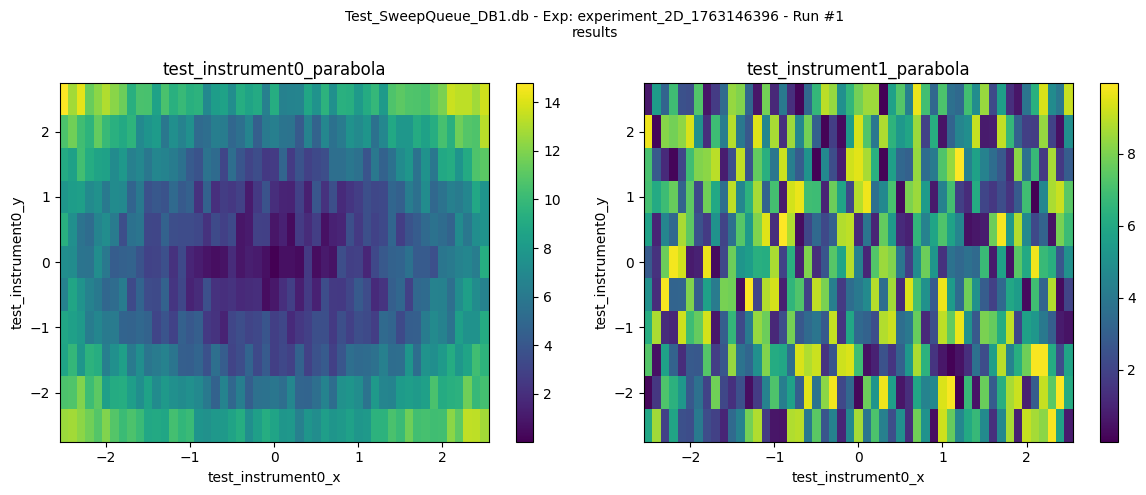

      Data summary:
        test_instrument0_x: min=-2.500, max=2.500, mean=0.020
        time: min=0.002, max=6.483, mean=3.235
        test_instrument0_y: min=-2.500, max=2.500, mean=0.000
        test_instrument0_parabola: min=0.037, max=14.804, mean=6.154
        test_instrument1_parabola: min=0.000, max=9.983, mean=4.992

    Dataset #2: results
      Started: 2025-11-14 13:55:09
      Points: 66
      Parameters: test_instrument1_x, time, test_instrument0_parabola, test_instrument1_parabola
      Sweep type: Sweep1D
      Plotting dataset #2...


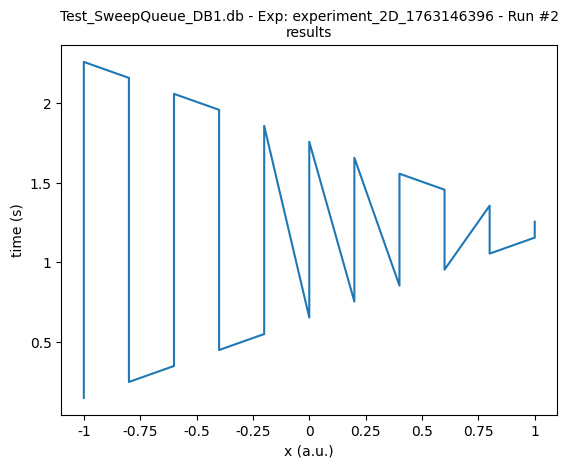

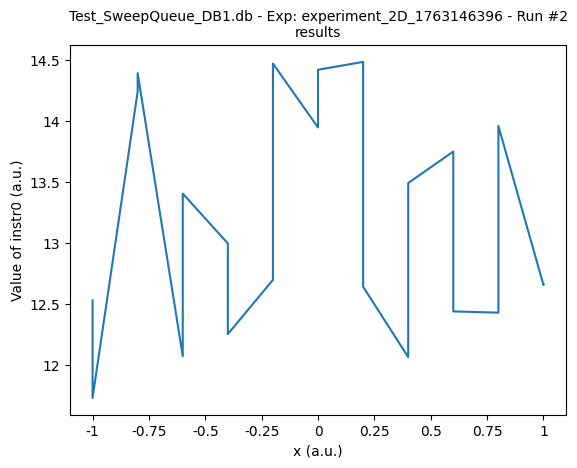

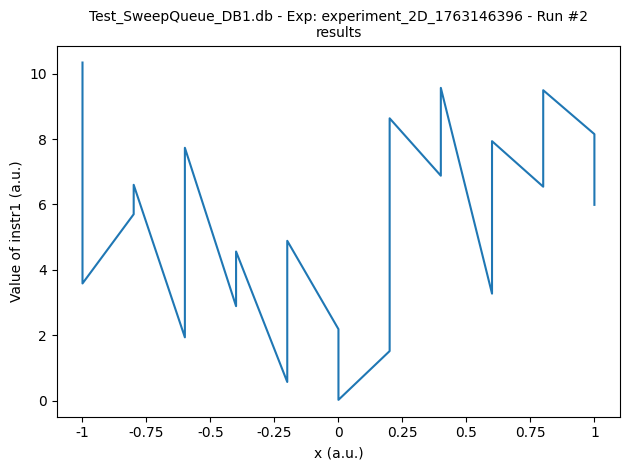

      Data summary:
        test_instrument1_x: min=-1.000, max=1.000, mean=-0.000
        time: min=0.150, max=2.258, mean=1.205
        test_instrument0_parabola: min=11.726, max=14.486, mean=13.168
        test_instrument1_parabola: min=0.021, max=10.342, mean=5.408

Analyzing: Test_SweepQueue_DB2.db
Path: /home/wangs/instrmcptest/Databases/Test_SweepQueue_DB2.db
Found 1 experiment(s):

  Experiment: experiment_final_1763146396
  Sample: sample_final
  Started: 1763146512.6665587
  Contains 2 dataset(s):

    Dataset #1: results
      Started: 2025-11-14 13:55:24
      Points: 2008
      Parameters: test_instrument0_x, time, test_instrument1_x, test_instrument0_parabola, test_instrument1_parabola
      Sweep type: SimulSweep
      Plotting dataset #1...


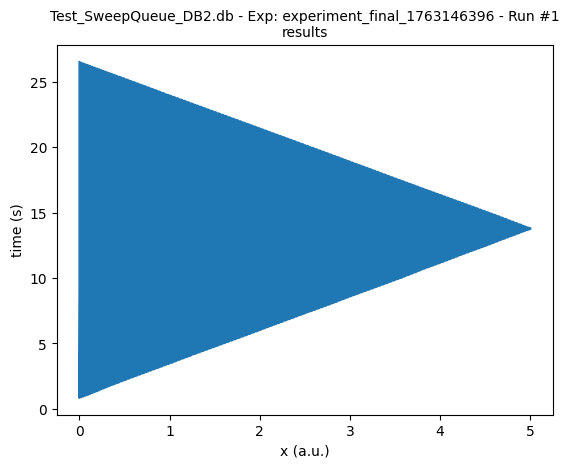

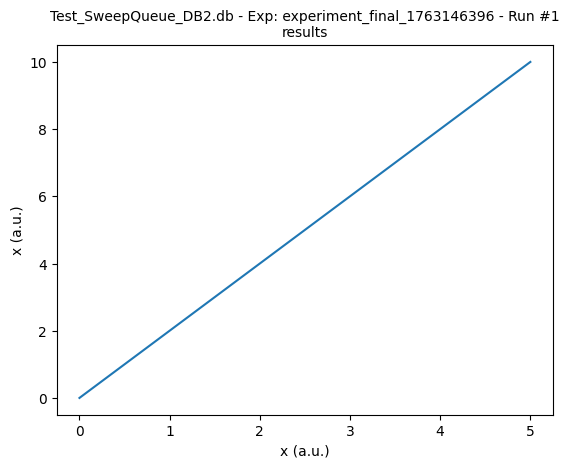

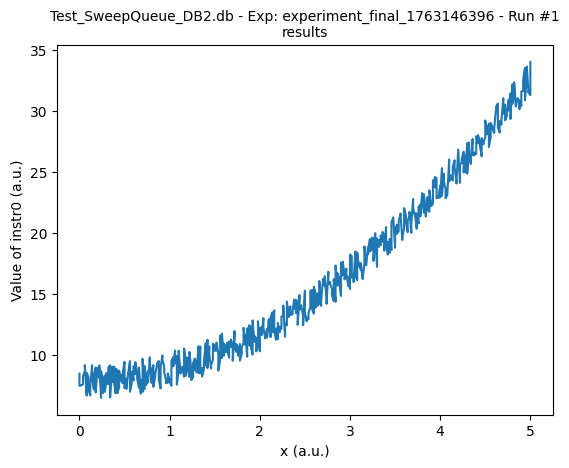

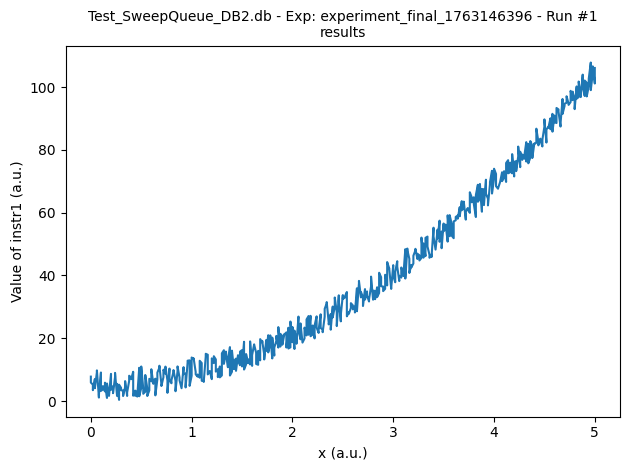

      Data summary:
        test_instrument0_x: min=-0.000, max=5.000, mean=2.500
        time: min=0.835, max=26.533, mean=13.741
        test_instrument1_x: min=-0.000, max=10.000, mean=5.000
        test_instrument0_parabola: min=6.451, max=34.008, mean=16.095
        test_instrument1_parabola: min=0.373, max=107.804, mean=38.088

    Dataset #2: results
      Started: 2025-11-14 13:55:51
      Points: 18
      Parameters: test_instrument0_x, time, test_instrument0_parabola, test_instrument1_parabola
      Sweep type: Sweep1D
      Plotting dataset #2...


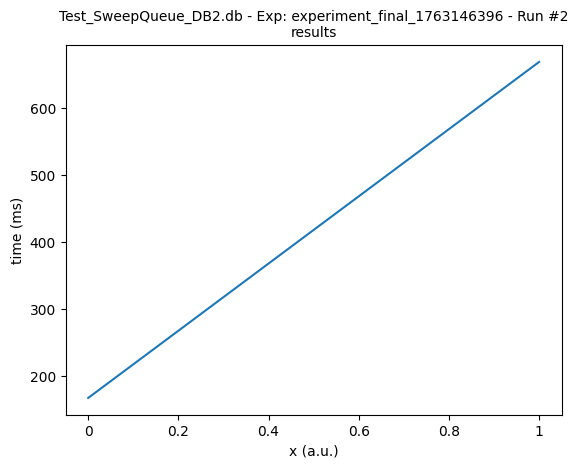

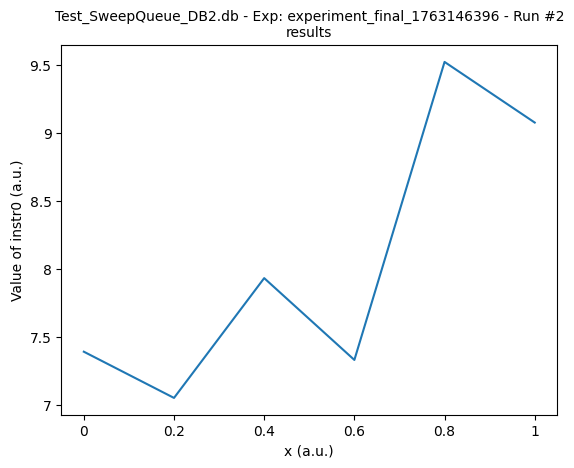

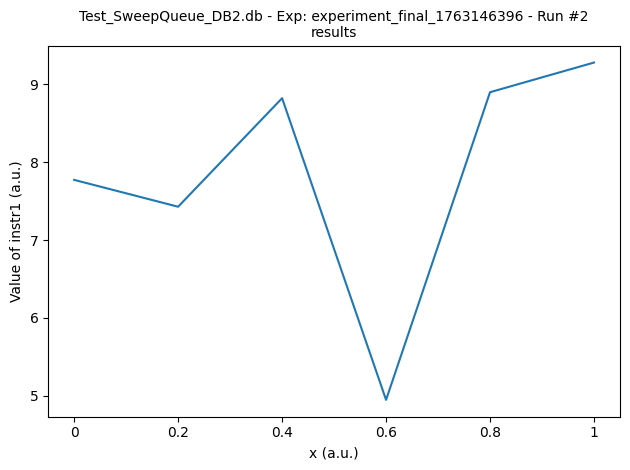

      Data summary:
        test_instrument0_x: min=0.000, max=1.000, mean=0.500
        time: min=0.167, max=0.668, mean=0.418
        test_instrument0_parabola: min=7.053, max=9.521, mean=8.051
        test_instrument1_parabola: min=4.946, max=9.281, mean=7.858

VERIFICATION SUMMARY

Datasets found:
  Default database: 0 dataset(s)
  Test_SweepQueue_DB1.db: 2 dataset(s)
  Test_SweepQueue_DB2.db: 2 dataset(s)
  Total: 4 dataset(s)

Expected results if all fixes are working:
1. Default database should contain:
   - 1D Sweep (s1)
   - SimulSweep (s2)

2. Test_SweepQueue_DB1.db should contain:
   - 2D Sweep (s3_2d)
   - 1D Sweep (s4)

3. Test_SweepQueue_DB2.db should contain:
   - SimulSweep (s5)
   - 1D Sweep (s6)

4. All datasets should have data points (not empty)
5. Plots should show the expected sweep patterns

VERIFICATION COMPLETE

Creating combined overview figure...


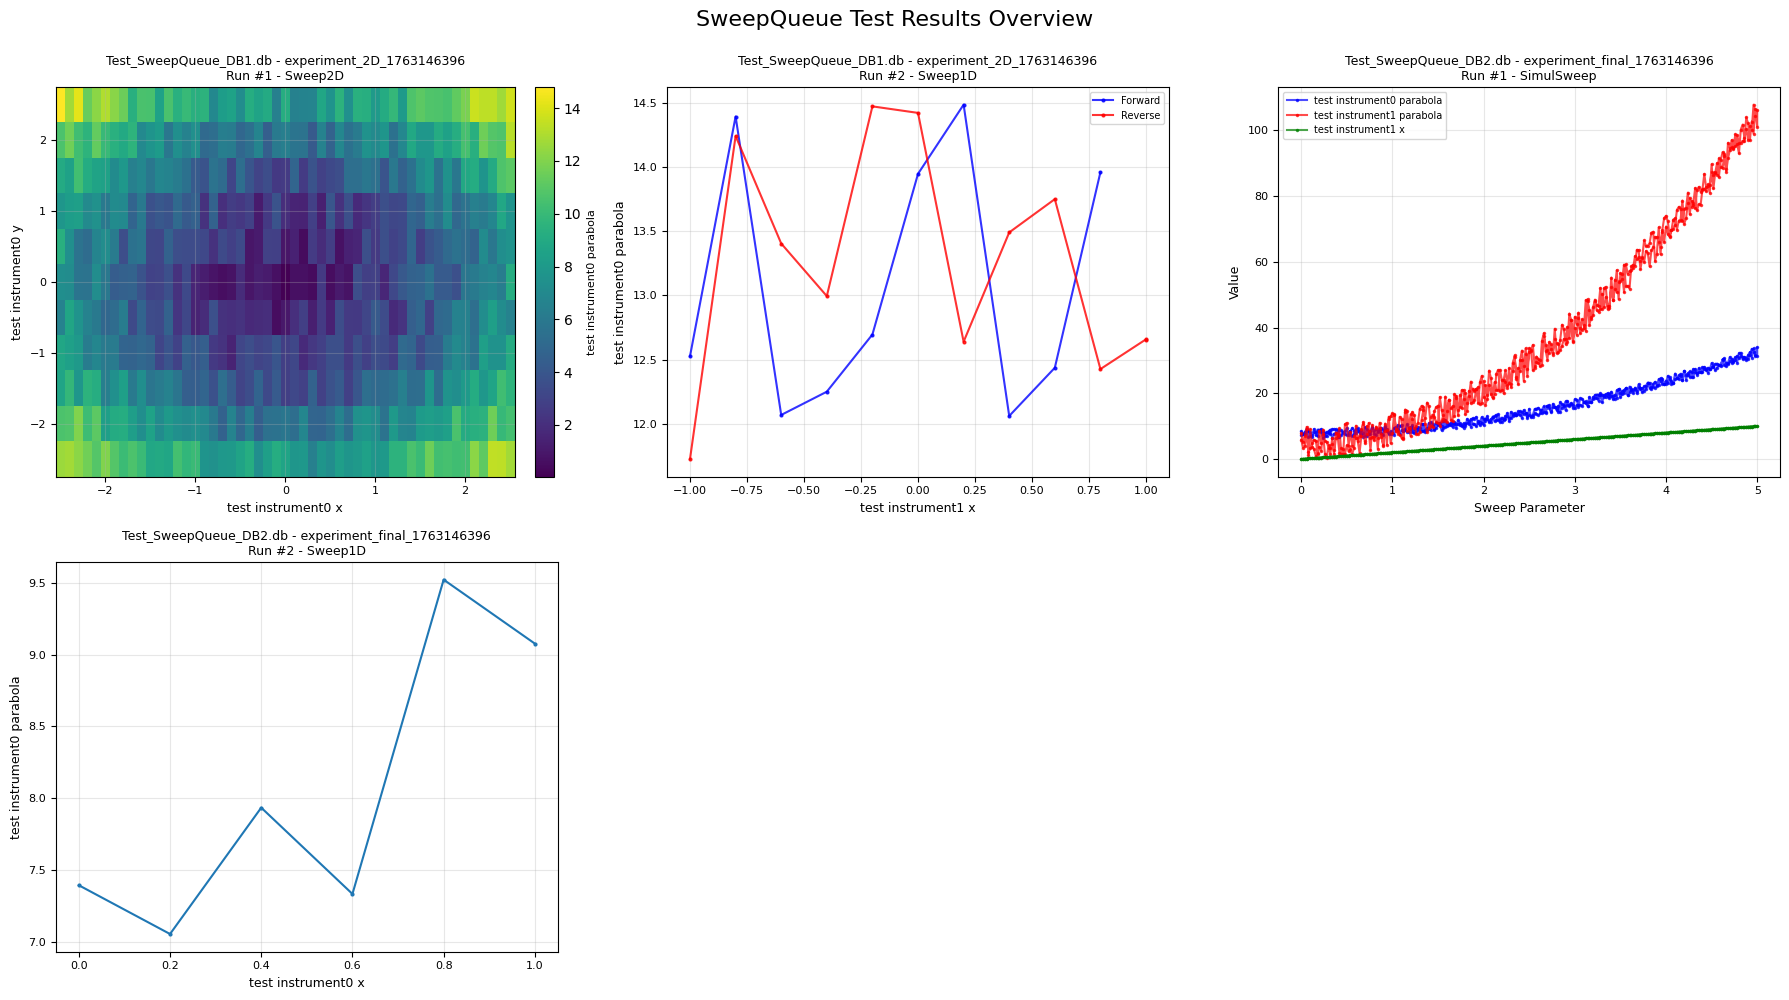

Plotted overview of 4 datasets (out of 4 total)

✅ Verification script complete!
Check the plots and output above to verify all sweeps were saved correctly.


In [22]:
"""
Script to verify and plot data saved by the SweepQueue test.
Loads data from the test databases and creates plots to verify all sweeps were saved correctly.
"""

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import qcodes as qc
from qcodes import experiments
from qcodes.dataset.plotting import plot_dataset

from measureit.config import get_path

# Define the database paths
db_name1 = "Test_SweepQueue_DB1.db"
db_name2 = "Test_SweepQueue_DB2.db"
db_path1 = str(get_path("databases") / db_name1)
db_path2 = str(get_path("databases") / db_name2)

# Also check default database for initial sweeps
default_db = str(
    get_path("databases") / "Test_.db"
)  # Adjust if your default is different

print("=" * 80)
print("SWEEP QUEUE DATA VERIFICATION")
print("=" * 80)


def analyze_database(db_path, db_name):
    """Analyze a database and plot all datasets."""
    print(f"\n{'=' * 60}")
    print(f"Analyzing: {db_name}")
    print(f"Path: {db_path}")
    print("=" * 60)

    if not Path(db_path).exists():
        print(f"⚠️  Database {db_name} does not exist!")
        return

    # Initialize database
    qc.config.core.db_location = db_path
    qc.initialise_or_create_database_at(db_path)

    # Get all experiments
    exps = experiments()

    if not exps:
        print(f"⚠️  No experiments found in {db_name}")
        return

    print(f"Found {len(exps)} experiment(s):")

    for exp in exps:
        print(f"\n  Experiment: {exp.name}")
        print(f"  Sample: {exp.sample_name}")
        print(f"  Started: {exp.started_at}")

        # Load all datasets in this experiment
        datasets = exp.data_sets()

        if not datasets:
            print("    No datasets in this experiment")
            continue

        print(f"  Contains {len(datasets)} dataset(s):")

        for ds in datasets:
            print(f"\n    Dataset #{ds.run_id}: {ds.name}")
            print(f"      Started: {ds.run_timestamp()}")
            print(f"      Points: {ds.number_of_results}")
            print(f"      Parameters: {', '.join(ds.parameters.split(','))}")

            # Get metadata
            metadata = ds.get_metadata("measureit")
            meta_dict = None
            sweep_type = "Unknown"
            if metadata:
                import json

                try:
                    meta_dict = json.loads(metadata)
                    sweep_type = meta_dict.get("class", "Unknown")
                    print(f"      Sweep type: {sweep_type}")
                except:
                    pass

            # Plot the dataset
            if ds.number_of_results > 0:
                try:
                    print(f"      Plotting dataset #{ds.run_id}...")

                    # For 2D sweeps, use custom plotting
                    if meta_dict and "Sweep2D" in sweep_type:
                        from scipy.interpolate import griddata

                        all_param_data = ds.get_parameter_data()

                        # Extract parameter names from metadata (meta_dict is already parsed)
                        if "inner_sweep" in meta_dict and "outer_sweep" in meta_dict:
                            inner_param_name = f"{meta_dict['inner_sweep']['instr_name']}_{meta_dict['inner_sweep']['param']}"
                            outer_param_name = f"{meta_dict['outer_sweep']['instr_name']}_{meta_dict['outer_sweep']['param']}"

                            # Find coordinate data
                            coord_data = None
                            for param_name, param_dict in all_param_data.items():
                                if (
                                    inner_param_name in param_dict
                                    and outer_param_name in param_dict
                                ):
                                    coord_data = param_dict
                                    break

                            if coord_data:
                                x_data = np.array(coord_data[inner_param_name])
                                y_data = np.array(coord_data[outer_param_name])

                                # Get follow parameters
                                follow_params = [
                                    p
                                    for p in all_param_data.keys()
                                    if p != "time"
                                    and p != inner_param_name
                                    and p != outer_param_name
                                ]

                                if follow_params:
                                    n_params = len(follow_params)
                                    fig, axes = plt.subplots(
                                        1, n_params, figsize=(6 * n_params, 5)
                                    )
                                    if n_params == 1:
                                        axes = [axes]

                                    for i, z_param in enumerate(follow_params):
                                        z_data = np.array(
                                            all_param_data[z_param][z_param]
                                        )

                                        # Create regular grid
                                        x_unique = np.unique(x_data)
                                        y_unique = np.unique(y_data)

                                        if len(x_unique) > 1 and len(y_unique) > 1:
                                            X, Y = np.meshgrid(x_unique, y_unique)
                                            Z = griddata(
                                                (x_data, y_data),
                                                z_data,
                                                (X, Y),
                                                method="linear",
                                            )

                                            im = axes[i].pcolormesh(
                                                X, Y, Z, shading="auto", cmap="viridis"
                                            )
                                            plt.colorbar(im, ax=axes[i])
                                            axes[i].set_xlabel(inner_param_name)
                                            axes[i].set_ylabel(outer_param_name)
                                            axes[i].set_title(z_param)
                                        else:
                                            sc = axes[i].scatter(
                                                x_data,
                                                y_data,
                                                c=z_data,
                                                s=10,
                                                cmap="viridis",
                                            )
                                            plt.colorbar(sc, ax=axes[i])
                                            axes[i].set_xlabel(inner_param_name)
                                            axes[i].set_ylabel(outer_param_name)
                                            axes[i].set_title(z_param)

                                    fig.suptitle(
                                        f"{db_name} - Exp: {exp.name} - Run #{ds.run_id}\n{ds.name}",
                                        fontsize=10,
                                    )
                                    plt.tight_layout()
                                    plt.show()
                        else:
                            # Use default plotting for non-2D sweeps
                            axes, cbars = plot_dataset(ds)
                            if axes:
                                for ax in axes:
                                    ax.set_title(
                                        f"{db_name} - Exp: {exp.name} - Run #{ds.run_id}\n{ds.name}",
                                        fontsize=10,
                                    )
                            plt.tight_layout()
                            plt.show()
                    else:
                        # Use default plotting for non-2D sweeps
                        axes, cbars = plot_dataset(ds)
                        if axes:
                            for ax in axes:
                                ax.set_title(
                                    f"{db_name} - Exp: {exp.name} - Run #{ds.run_id}\n{ds.name}",
                                    fontsize=10,
                                )
                        plt.tight_layout()
                        plt.show()

                    # Also create a summary of the data
                    print("      Data summary:")
                    for param_name in ds.parameters.split(","):
                        if param_name:
                            try:
                                data = ds.get_parameter_data(param_name)
                                for key, values in data.items():
                                    if (
                                        key == param_name
                                        and len(values[param_name]) > 0
                                    ):
                                        arr = np.array(values[param_name])
                                        print(
                                            f"        {param_name}: min={np.min(arr):.3f}, "
                                            f"max={np.max(arr):.3f}, "
                                            f"mean={np.mean(arr):.3f}"
                                        )
                            except Exception:
                                pass

                except Exception as e:
                    print(f"      ⚠️  Could not plot dataset: {e}")
            else:
                print("      ⚠️  No data points to plot")


# Analyze default database
print("\n" + "=" * 80)
print("CHECKING DEFAULT DATABASE")
print("=" * 80)
analyze_database(default_db, "Default Database (experiments.db)")

# Analyze test database 1
analyze_database(db_path1, db_name1)

# Analyze test database 2
analyze_database(db_path2, db_name2)

# Summary statistics
print("\n" + "=" * 80)
print("VERIFICATION SUMMARY")
print("=" * 80)


def count_datasets(db_path):
    """Count total datasets in a database."""
    if not Path(db_path).exists():
        return 0

    qc.config.core.db_location = db_path
    qc.initialise_or_create_database_at(db_path)

    total = 0
    for exp in experiments():
        total += len(exp.data_sets())
    return total


# Count datasets in each database
default_count = count_datasets(default_db)
db1_count = count_datasets(db_path1)
db2_count = count_datasets(db_path2)

print("\nDatasets found:")
print(f"  Default database: {default_count} dataset(s)")
print(f"  {db_name1}: {db1_count} dataset(s)")
print(f"  {db_name2}: {db2_count} dataset(s)")
print(f"  Total: {default_count + db1_count + db2_count} dataset(s)")

print("\n" + "=" * 80)
print("Expected results if all fixes are working:")
print("=" * 80)
print("1. Default database should contain:")
print("   - 1D Sweep (s1)")
print("   - SimulSweep (s2)")
print("\n2. Test_SweepQueue_DB1.db should contain:")
print("   - 2D Sweep (s3_2d)")
print("   - 1D Sweep (s4)")
print("\n3. Test_SweepQueue_DB2.db should contain:")
print("   - SimulSweep (s5)")
print("   - 1D Sweep (s6)")
print("\n4. All datasets should have data points (not empty)")
print("5. Plots should show the expected sweep patterns")

print("\n" + "=" * 80)
print("VERIFICATION COMPLETE")
print("=" * 80)

# Create a combined figure showing all sweep results
print("\nCreating combined overview figure...")

# Collect all datasets first
all_datasets = []
for db_path, db_name in [
    (default_db, "Default DB"),
    (db_path1, db_name1),
    (db_path2, db_name2),
]:
    if Path(db_path).exists():
        qc.config.core.db_location = db_path
        qc.initialise_or_create_database_at(db_path)
        for exp in experiments():
            for ds in exp.data_sets():
                if ds.number_of_results > 0:
                    all_datasets.append((ds, db_name, exp.name))

if len(all_datasets) == 0:
    print("No datasets with data found to plot!")
else:
    # Create figure with proper number of subplots
    n_datasets = min(len(all_datasets), 9)  # Limit to 9 for visibility
    n_cols = min(3, n_datasets)
    n_rows = (n_datasets + n_cols - 1) // n_cols

    fig = plt.figure(figsize=(6 * n_cols, 5 * n_rows))
    fig.suptitle("SweepQueue Test Results Overview", fontsize=16, y=0.995)

    for idx, (ds, db_name, exp_name) in enumerate(all_datasets[:9], 1):
        ax = plt.subplot(n_rows, n_cols, idx)

        try:
            # Get sweep type from metadata
            sweep_type = "Unknown"
            metadata = ds.get_metadata("measureit")
            if metadata:
                import json

                meta_dict = json.loads(metadata)
                sweep_type = meta_dict.get("class", "Unknown")

            # Get all parameter data
            all_param_data = ds.get_parameter_data()

            # Identify independent and dependent parameters
            params_info = ds.description.interdeps
            param_names = list(all_param_data.keys())

            # For 2D sweeps
            if "Sweep2D" in sweep_type:
                # Check if metadata has inner_sweep and outer_sweep structure
                if (
                    metadata
                    and "inner_sweep" in meta_dict
                    and "outer_sweep" in meta_dict
                ):
                    # Extract parameter names from metadata
                    inner_param_name = f"{meta_dict['inner_sweep']['instr_name']}_{meta_dict['inner_sweep']['param']}"
                    outer_param_name = f"{meta_dict['outer_sweep']['instr_name']}_{meta_dict['outer_sweep']['param']}"

                    # Find coordinate data from any parameter that has both setpoints
                    coord_data = None
                    for param_name, param_dict in all_param_data.items():
                        if (
                            inner_param_name in param_dict
                            and outer_param_name in param_dict
                        ):
                            coord_data = param_dict
                            break

                    if coord_data:
                        x_data = np.array(
                            coord_data[inner_param_name]
                        )  # Inner sweep (x-axis)
                        y_data = np.array(
                            coord_data[outer_param_name]
                        )  # Outer sweep (y-axis)

                        # Get follow parameters (exclude time and sweep parameters)
                        follow_params = [
                            p
                            for p in all_param_data.keys()
                            if p != "time"
                            and p != inner_param_name
                            and p != outer_param_name
                        ]

                        if follow_params:
                            # Plot first follow parameter
                            z_param = follow_params[0]
                            z_data = np.array(all_param_data[z_param][z_param])

                            # Create regular grid for pcolormesh
                            x_unique = np.unique(x_data)
                            y_unique = np.unique(y_data)

                            if len(x_unique) > 1 and len(y_unique) > 1:
                                from scipy.interpolate import griddata

                                X, Y = np.meshgrid(x_unique, y_unique)

                                # Interpolate irregular data to regular grid
                                Z = griddata(
                                    (x_data, y_data), z_data, (X, Y), method="linear"
                                )

                                # Plot heatmap
                                im = ax.pcolormesh(
                                    X, Y, Z, shading="auto", cmap="viridis"
                                )
                                cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                                cbar.set_label(z_param.replace("_", " "), fontsize=8)
                                ax.set_xlabel(
                                    inner_param_name.replace("_", " "), fontsize=9
                                )
                                ax.set_ylabel(
                                    outer_param_name.replace("_", " "), fontsize=9
                                )
                            else:
                                # Fallback to scatter
                                sc = ax.scatter(
                                    x_data, y_data, c=z_data, s=10, cmap="viridis"
                                )
                                plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
                                ax.set_xlabel(
                                    inner_param_name.replace("_", " "), fontsize=9
                                )
                                ax.set_ylabel(
                                    outer_param_name.replace("_", " "), fontsize=9
                                )

            # For SimulSweep
            elif "SimulSweep" in sweep_type:
                # Plot multiple parameters on same axes
                colors = ["b", "r", "g", "c", "m", "y"]
                plotted = 0

                for param_name in param_names:
                    if "time" not in param_name.lower() and plotted < 3:
                        param_data = all_param_data[param_name]
                        # Check if this is a dependent parameter
                        if len(param_data) > 1:
                            # Find the independent parameter
                            indep_param = None
                            for key in param_data.keys():
                                if key != param_name and "time" not in key.lower():
                                    indep_param = key
                                    break

                            if indep_param:
                                x_data = np.array(param_data[indep_param])
                                y_data = np.array(param_data[param_name])
                                ax.plot(
                                    x_data,
                                    y_data,
                                    ".-",
                                    markersize=3,
                                    color=colors[plotted % len(colors)],
                                    label=param_name.replace("_", " "),
                                    alpha=0.7,
                                )
                                plotted += 1

                if plotted > 0:
                    ax.set_xlabel("Sweep Parameter", fontsize=9)
                    ax.set_ylabel("Value", fontsize=9)
                    ax.legend(fontsize=7, loc="best")

            # For regular 1D sweeps
            else:
                # Find first plottable parameter pair
                plotted = False
                for param_name in param_names:
                    if not plotted and "time" not in param_name.lower():
                        param_data = all_param_data[param_name]
                        if len(param_data) > 1:
                            # This is a dependent parameter
                            # Find its independent parameter
                            for indep_name in param_data.keys():
                                if (
                                    indep_name != param_name
                                    and "time" not in indep_name.lower()
                                ):
                                    x_data = np.array(param_data[indep_name])
                                    y_data = np.array(param_data[param_name])

                                    # Check for bidirectional sweep
                                    if len(x_data) > 2:
                                        dx = np.diff(x_data)
                                        if np.any(dx < 0) and np.any(dx > 0):
                                            # Bidirectional - show with colors
                                            turning_point = np.where(
                                                np.diff(np.sign(dx))
                                            )[0]
                                            if len(turning_point) > 0:
                                                tp = turning_point[0] + 1
                                                ax.plot(
                                                    x_data[:tp],
                                                    y_data[:tp],
                                                    "b.-",
                                                    markersize=4,
                                                    label="Forward",
                                                    alpha=0.8,
                                                )
                                                ax.plot(
                                                    x_data[tp:],
                                                    y_data[tp:],
                                                    "r.-",
                                                    markersize=4,
                                                    label="Reverse",
                                                    alpha=0.8,
                                                )
                                                ax.legend(fontsize=7)
                                            else:
                                                ax.plot(
                                                    x_data, y_data, ".-", markersize=4
                                                )
                                        else:
                                            ax.plot(x_data, y_data, ".-", markersize=4)
                                    else:
                                        ax.plot(x_data, y_data, "o-", markersize=5)

                                    ax.set_xlabel(
                                        indep_name.replace("_", " "), fontsize=9
                                    )
                                    ax.set_ylabel(
                                        param_name.replace("_", " "), fontsize=9
                                    )
                                    plotted = True
                                    break

            # Add title and grid
            title = f"{db_name} - {exp_name}\nRun #{ds.run_id} - {sweep_type}"
            ax.set_title(title, fontsize=9, pad=5)
            ax.grid(True, alpha=0.3)
            ax.tick_params(labelsize=8)

        except Exception as e:
            ax.text(
                0.5,
                0.5,
                f"Error plotting\nRun #{ds.run_id}\n{str(e)[:50]}",
                ha="center",
                va="center",
                transform=ax.transAxes,
                fontsize=8,
            )
            ax.set_title(f"{db_name} - Run #{ds.run_id}", fontsize=9)

    plt.tight_layout()
    plt.show()

    print(
        f"Plotted overview of {min(n_datasets, 9)} datasets (out of {len(all_datasets)} total)"
    )

print("\n✅ Verification script complete!")
print("Check the plots and output above to verify all sweeps were saved correctly.")